# PUBG population simulation
Let's assume 

N - Population

$\rho$ - density or #people / area

$\alpha$ - Killing Coefficient
$$\frac{dN}{dt}=-\alpha\rho N(t)$$

This equation is based on 2 facts
* With the same #people, more density make people meet each other easily and start killing
* With the same density, number of killing proportional to the #people
    
The equation can be rewrote as 
$$\frac{dN}{dt}=-\alpha\frac{N(t)}{A(t)} N(t)=-\alpha\frac{N(t)^2}{A(t)}$$
which solve easily by integrate from $t=0$ to $t=t_n$
$$\int_{0}^{N(t_n)}-\frac{1}{\alpha N^2}dN=\int_{0}^{t_n}\frac{1}{A(t)}dt$$
$$(\Rightarrow) \ N(t_n)=\frac{1}{\alpha\phi(t_n)+1/N(0)}$$
which $\phi(t_n)=\int_{0}^{t_n}\frac{1}{A(t)}dt$

In the later part, we will observe more about $\alpha$ value and find its relationship

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress
from Actor import PlayerActor

from scipy.optimize import curve_fit

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Let's draw the Area graph

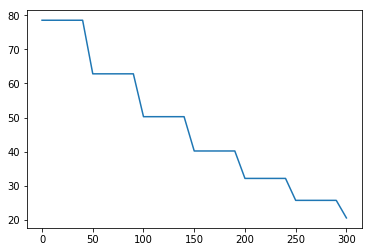

In [2]:
TIMES_PER_STEP = 50
DROPPING_TIME = 10
def Area(t):
    step = t // TIMES_PER_STEP
    current_area = (0.8) ** step * 25 * np.pi
    remainder = t % TIMES_PER_STEP
    if remainder > (TIMES_PER_STEP - DROPPING_TIME):
        next_area = (0.8) ** (step + 1) * 25 * np.pi
        return current_area + (next_area - current_area) * (remainder - (TIMES_PER_STEP - DROPPING_TIME)) / DROPPING_TIME
        
    return current_area

areas = np.array([Area(t) for t in range(301)])
plt.plot(areas)

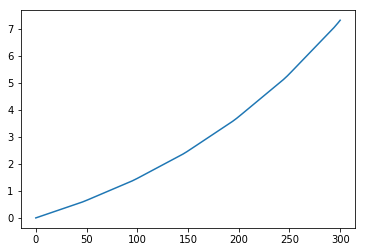

In [3]:
def phi(t):
    if type(t) is np.ndarray:
        out = []
        for i in t:
            out.append(np.sum(1/areas[:int(i)]))
        return np.array(out)
            
    return np.sum(1/areas[:int(t)])

phiss = [phi(i) for i in range(301)]
plt.plot(phiss)

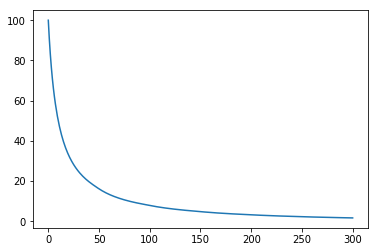

In [5]:
alpha = 0.08
def N(t):
    return 1 / (alpha * phi(t) + 1 / 100)

plt.plot([N(t) for t in range(301)])

In [21]:
ACTOR_NUM = 100
ADVANTAGE_NUM = 40

SQ_FIELD_WIDTH = 10
R_RESTRICT = 5

KILLING_DISTANCE = 0.1

actor_list = [PlayerActor(SQ_FIELD_WIDTH, ADVANTAGE_NUM, i) for i in range(ACTOR_NUM)]
advantage_points = np.random.uniform(-SQ_FIELD_WIDTH/2, SQ_FIELD_WIDTH/2, size=(ADVANTAGE_NUM, 2))
advantage_points[-1] = [0,0] # Let's make it center
advantage_points_met = [False for _ in range(ADVANTAGE_NUM)]
counter = 0
survive_num = []

def massecre():
    global actor_list, killing_list
    positions = np.array(list(map(lambda x: x.pos, actor_list)))
    index_random = np.random.permutation(len(actor_list))
    alive = [True for _ in range(len(actor_list))]
    for i in index_random:
        if not alive[i]:
            continue
        for j in index_random:
            if not alive[j] or i == j:
                continue
            if np.linalg.norm(positions[i] - positions[j]) < KILLING_DISTANCE:
                sum_power = actor_list[i].power + actor_list[j].power
                to_live, to_die = np.random.choice([i,j], size=2, replace=False, \
                    p=[float(actor_list[i].power)/sum_power, float(actor_list[j].power)/sum_power])
                actor_list[to_live].power = max(actor_list[to_live].power - 30, 50)
                alive[to_die] = False
                actor_list[to_live].kill += 1

    actor_list = list(compress(actor_list, alive))

    


def render():
    global R_RESTRICT, counter, actor_list, survive_num, advantage_points_met
    
    R_RESTRICT = np.sqrt(Area(t) / np.pi)

    for i in np.random.permutation(len(actor_list)):
        actor_list[i].move(R_RESTRICT, advantage_points)
        actor_list[i].check_advantage_point(advantage_points, advantage_points_met)
    counter += 1

    massecre()

    return len(actor_list)

In [22]:
counter = 0
no_people = []
for i in range(300):
    no_people.append(render())
    
no_people = np.array(no_people)

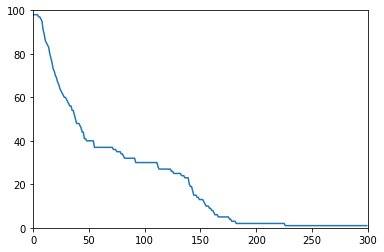

In [23]:
plt.xlim(0,300)
plt.ylim(0,100)
plt.plot(no_people)

# Fit the curve
Levenberg–Marquardt algorithm

In [17]:
def N_fit(t, alpha):
    value = 1 / (alpha * phi(t) + 1 / 100)
    return value

In [24]:
opt, _ = curve_fit(N_fit, np.arange(300), no_people, p0=(0.05))

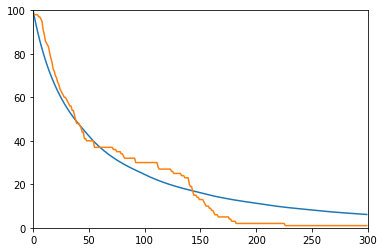

In [25]:
plt.xlim(0,300)
plt.ylim(0,100)
plt.plot(N_fit(np.arange(300), *opt))
# plt.scatter(np.arange(1,301)[sampling_point], no_people[sampling_point + 1])
plt.plot(no_people)

In [26]:
opt

array([0.02105974])